In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import *
import seaborn as sns
sns.set()
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scripts import utils
from scripts import metrics 
from scripts.dataset import SimpleSeqsDataset
from scripts.training import *

print(torch.__version__)
os.chdir('./Data')

os.listdir()[:3]

1.4.0


['chr15.fa.fai', 'chr19.fa.fai', 'chr4.fa']

In [2]:
chromosomes = list(range(1,23)) + ['M','X','Y']
data_full = utils.merge_chrom_data('chr', chromosomes)
print(data_full.shape)
print('not longer than 500bp:', sum(data_full.len <= 500) / data_full.shape[0])
pd.DataFrame(data_full.len.describe())

['chr1' 'chr2' 'chr3' 'chr4' 'chr5' 'chr6' 'chr7' 'chr8' 'chr9' 'chr10'
 'chr11' 'chr12' 'chr13' 'chr14' 'chr15' 'chr16' 'chr17' 'chr18' 'chr19'
 'chr20' 'chr21' 'chr22' 'chrM' 'chrX' 'chrY']
(8955, 5)
not longer than 500bp: 0.9711892797319933


,len
count,8955.000000
mean,226.098157
std,132.413339
min,1.000000
25%,142.000000
50%,205.000000
75%,285.000000
max,5502.000000


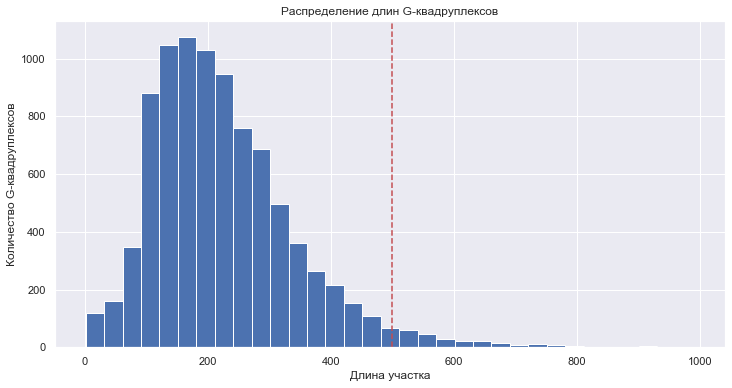

In [3]:
ax = data_full[data_full.len<1000].len.hist(bins=np.arange(data_full.len.min(),1000,30),figsize=(12,6))
ax.set_ylabel('Количество G-квадруплексов')
ax.set_xlabel('Длина участка')
ax.set_title('Распределение длин G-квадруплексов')
ax.axvline(500,color='r', linestyle='--')
plt.savefig('../g_quadruplexes.png')

In [4]:
print('Координаты G-квадруплексов после удаления слишком длинных и центрирования:')
utils.center_seq(500).head()

Координаты G-квадруплексов после удаления слишком длинных и центрирования:
Start shape: (8955, 4)
Final shape: (8697, 6)


,chr,start,end,len,new_start,new_end
0,chr1,713977,714310,333,713894,714394
1,chr1,762850,762982,132,762666,763166
2,chr1,840076,840205,129,839891,840391
3,chr1,894635,894796,161,894466,894966
4,chr1,935414,935699,285,935307,935807


In [5]:
chromosomes = list(range(1,23)) + ['M','X','Y']
df = utils.merge_chrom_data('chr', chromosomes, '_centered')
df.head()

['chr1' 'chr2' 'chr3' 'chr4' 'chr5' 'chr6' 'chr7' 'chr8' 'chr9' 'chr10'
 'chr11' 'chr12' 'chr13' 'chr14' 'chr15' 'chr16' 'chr17' 'chr18' 'chr19'
 'chr20' 'chr21' 'chr22' 'chrM' 'chrX' 'chrY']


,chr,start,end,seq,len
0,chr1,713894,714394,TTCAGCCGGCAACACACAGAACCTGGCGGGGAGGTCACTCTTACCA...,500
1,chr1,762666,763166,ACCGGACACAGACGCAGATCTGGCAGCTGAGCGACAGGCTTCGGAG...,500
2,chr1,839891,840391,ACGTGGCCTCCTCCGAACGCGGCCGCCTCCTCCTCCGAACGCGGCC...,500
3,chr1,894466,894966,GGTCACGCAGGAGTCACAGCTGCCCGCACGCCCAGCTCGCCCCAGC...,500
4,chr1,935307,935807,CTGCCATCGGCGAGGCGCTCGGTTTCCCCGGCGTGTCTGCGGCCAT...,500


In [6]:
# Load shuffled data 
chromosomes = list(range(1,23)) + ['M','X','Y']
shuf = utils.merge_chrom_data('shuffled_chr', chromosomes)
shuf.head()

['chr1' 'chr2' 'chr3' 'chr4' 'chr5' 'chr6' 'chr7' 'chr8' 'chr9' 'chr10'
 'chr11' 'chr12' 'chr13' 'chr14' 'chr15' 'chr16' 'chr17' 'chr18' 'chr19'
 'chr20' 'chr21' 'chr22' 'chrM' 'chrX' 'chrY']


,chr,start,end,seq,len
0,chr1,113133816,113134316,tgctgggattacaggtgtgagccaccacacccggccTAGTATGTTA...,500
1,chr1,180867994,180868494,ctttaaaatgcctttggtcccaagtctctgacaggagggtgaggtg...,500
2,chr1,95276940,95277440,gggcaaagaacccgcatcagcctgcctcatcattaaccctcaactg...,500
3,chr1,40094551,40095051,gcgtgagccaccgcgcccggccCGCTGTTTTTTTCTAACATTTGCT...,500
4,chr1,152882574,152883074,CAGAAAACCCAGAGCAGCAGCTTAAGCAGGAGAAAACACAAAGGGA...,500


In [7]:
# Split to test & train
test_chromosomes_list = [3,6,9,12,15,18,21]
test_chromosomes = list(map(lambda n:'chr'+str(n),test_chromosomes_list))
specific_chromosomes = ['chrX','chrM','chrY']

shuf['label'] = 0
test_shuf = shuf[shuf.chr.isin(test_chromosomes)]
train_shuf = shuf[~shuf.chr.isin(test_chromosomes + specific_chromosomes)]

df['label'] = 1
test_data = df[df.chr.isin(test_chromosomes)]
train_data = df[~df.chr.isin(test_chromosomes + specific_chromosomes)]

train_full = pd.concat([train_data,train_shuf]).reset_index(drop=True)
test_full = pd.concat([test_data,test_shuf]).reset_index(drop=True)

In [8]:
# Get X & y
train_X = utils.encode_seq(train_full.seq)
test_X = utils.encode_seq(test_full.seq)
train_y = train_full.label
test_y = test_full.label
np.array(test_y).shape

(4222,)

In [9]:
# Get train & test datasets
device = utils.get_device()      
BATCH_SIZE = 32
batch_num = len(train_X)//BATCH_SIZE
     
train_dataset = SimpleSeqsDataset(train_X, train_y)
test_dataset = SimpleSeqsDataset(test_X, test_y)

In [10]:
train_dataset.__getitem__(3)[0]

tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 1.]])

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4,out_channels=16, kernel_size=5)
        self.pool = nn.MaxPool1d(5)
        self.fc1 = nn.Linear(16*99, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, 16*99)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x
    
net = Net()
print(net)

Net(
  (conv1): Conv1d(4, 16, kernel_size=(5,), stride=(1,))
  (pool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1584, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


In [12]:
all_losses = []
all_accs = []

In [13]:
net = Net()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
all_losses, all_accs = train(net, 13, optimizer, train = train_dataset, batch_size = BATCH_SIZE,
                             eval_epochs = 0, use_wandb = False, all_losses = all_losses, all_accs = all_accs)

Epoch: 1, step:  100 | loss: 0.651 | acc: 80.440 
Epoch: 1, step:  200 | loss: 0.495 | acc: 89.810 
Epoch: 1, step:  300 | loss: 0.301 | acc: 90.340 
Epoch: 1, step:  400 | loss: 0.209 | acc: 92.650 
Epoch: 2, step:  100 | loss: 0.182 | acc: 94.560 
Epoch: 2, step:  200 | loss: 0.201 | acc: 93.000 
Epoch: 2, step:  300 | loss: 0.185 | acc: 93.570 
Epoch: 2, step:  400 | loss: 0.170 | acc: 94.260 
Epoch: 3, step:  100 | loss: 0.187 | acc: 93.000 
Epoch: 3, step:  200 | loss: 0.162 | acc: 94.610 
Epoch: 3, step:  300 | loss: 0.156 | acc: 94.580 
Epoch: 3, step:  400 | loss: 0.171 | acc: 94.130 
Epoch: 4, step:  100 | loss: 0.178 | acc: 93.560 
Epoch: 4, step:  200 | loss: 0.159 | acc: 94.590 
Epoch: 4, step:  300 | loss: 0.160 | acc: 94.570 
Epoch: 4, step:  400 | loss: 0.156 | acc: 94.590 
Epoch: 5, step:  100 | loss: 0.161 | acc: 94.490 
Epoch: 5, step:  200 | loss: 0.154 | acc: 94.660 
Epoch: 5, step:  300 | loss: 0.162 | acc: 94.370 
Epoch: 5, step:  400 | loss: 0.148 | acc: 94.420 


In [115]:
net = Net()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
all_losses, all_accs = train(net, 13, optimizer, train = train_dataset, batch_size = BATCH_SIZE,
                             eval_epochs = 0, use_wandb = False, all_losses = all_losses, all_accs = all_accs)

Epoch: 1, step:  100 | loss: 0.651 | acc: 75.700 
Epoch: 1, step:  200 | loss: 0.469 | acc: 93.460 
Epoch: 1, step:  300 | loss: 0.272 | acc: 93.430 
Epoch: 1, step:  400 | loss: 0.200 | acc: 93.240 
Epoch: 2, step:  100 | loss: 0.176 | acc: 93.940 
Epoch: 2, step:  200 | loss: 0.172 | acc: 94.080 
Epoch: 2, step:  300 | loss: 0.175 | acc: 93.790 
Epoch: 2, step:  400 | loss: 0.183 | acc: 93.490 
Epoch: 3, step:  100 | loss: 0.162 | acc: 94.010 
Epoch: 3, step:  200 | loss: 0.166 | acc: 94.200 
Epoch: 3, step:  300 | loss: 0.167 | acc: 93.730 
Epoch: 3, step:  400 | loss: 0.161 | acc: 94.510 
Epoch: 4, step:  100 | loss: 0.166 | acc: 93.920 
Epoch: 4, step:  200 | loss: 0.147 | acc: 95.210 
Epoch: 4, step:  300 | loss: 0.156 | acc: 94.040 
Epoch: 4, step:  400 | loss: 0.161 | acc: 94.220 
Epoch: 5, step:  100 | loss: 0.143 | acc: 94.560 
Epoch: 5, step:  200 | loss: 0.157 | acc: 93.980 
Epoch: 5, step:  300 | loss: 0.159 | acc: 94.120 
Epoch: 5, step:  400 | loss: 0.150 | acc: 94.890 


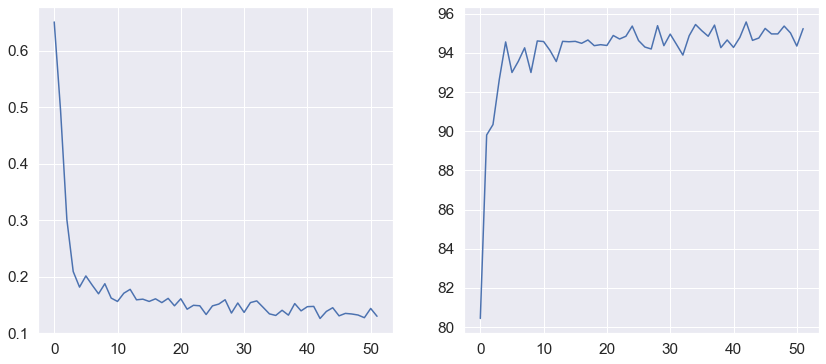

In [17]:
def plot_metric(metric_values):
    plt.plot(np.arange(len(metric_values)), metric_values)
plt.subplots(1,2, figsize=(14,6))
plt.subplot(1,2,1)
plot_metric(all_losses[-1])
plt.subplot(1,2,2)
plot_metric(all_accs[-1])

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2111
           1       0.97      0.95      0.96      2111

    accuracy                           0.96      4222
   macro avg       0.96      0.96      0.96      4222
weighted avg       0.96      0.96      0.96      4222



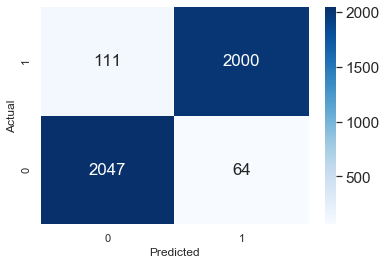

<Figure size 720x720 with 0 Axes>

In [16]:
y_labels_list, y_pred_list = evaluation(net, test_dataset, batch_size = 1)
metrics.plot_conf_matrix(y_labels_list, y_pred_list)

In [15]:
roc_auc_score(y_labels_list, y_pred_list)

0.9585504500236854